### Model complexity: Effect of memorizing data on performance 



In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
from src.models import NAVAR, NAVAR_UA, TAMCaD, TAMCaD_UA
from src.data import load_dataset
from src.training.train_model import train_model, train_test_split
from tqdm.notebook import trange, tqdm

In [2]:
dataset = load_dataset('synthetic', 'synthetic_N-5_T-300_K-5')[0]
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

{'name': 'synthetic_N-5_T-300_K-5', 'data': torch.Size([1, 5, 300]), 'data_noise_adjusted': torch.Size([1, 5, 300]), 'ground_truth': torch.Size([5, 5])}


In [3]:
default = {
    'experiment_name': 'complexity',
    'lr': 5e-4,
    'epochs': 3000,
    'test_size': 0.2,
    'hidden_dim': 8,
    'kernel_size': 2,
    'n_blocks': 3,
    'n_layers': 1,
    'dropout': 0.2,
    'lambda1': 0.1,
    'gamma': 0.0001,
    'use_gumbel': True
}

models = {
    'NAVAR': {'model_type': NAVAR},
    'NAVAR-WS': {'model_type': NAVAR, 'weight_sharing': True},
    'NAVAR-Rec': {'model_type': NAVAR, 'recurrent': True},
    'NAVAR-WS-Rec': {'model_type': NAVAR, 'recurrent': True, 'weight_sharing': True},
    'NAVAR-UA': {'model_type': NAVAR_UA, 'beta': 0.3, 'n_ensembles': 30, 'lambda1':0.1},
    'NAVAR-baseline': {'model_type': NAVAR, 'kernel_size': 3, 'n_blocks': 1, 'n_layers': 2},
    'TAMCaD': {'model_type': TAMCaD},
    'TAMCaD-WS': {'model_type': TAMCaD, 'weight_sharing': True},
    'TAMCaD-Rec': {'model_type': TAMCaD, 'recurrent': True},
    'TAMCaD-WS-Rec': {'model_type': TAMCaD, 'recurrent': True, 'weight_sharing': True},
    'TAMCaD-UA': {'model_type': TAMCaD_UA, 'gamma': 0.0, 'n_ensembles': 30, 'lambda1':0.1},
}

for name, params in models.items():
    for k, default_value in default.items():
        if k not in params:
            params[k] = default_value

In [4]:
all_results = {}

for model_name, params in models.items():
    print(model_name)
    all_results[model_name] = train_model(**params, dataset=dataset)

NAVAR


  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]C:\Users\mauri\.conda\envs\causal-discovery\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
[train] loss=0.65,noise=0.36,AUROC=0.99 [test] loss=0.67,noise=0.32,AUROC=0.97: 100%|█| 3000/3000 [00:35<00:00, 85.48it


NAVAR-WS


[train] loss=0.80,noise=0.43,AUROC=0.75 [test] loss=0.72,noise=0.39,AUROC=0.80: 100%|█| 3000/3000 [00:33<00:00, 88.66it


NAVAR-Rec


[train] loss=0.76,noise=0.40,AUROC=0.97 [test] loss=0.69,noise=0.33,AUROC=0.96: 100%|█| 3000/3000 [00:34<00:00, 86.92it


NAVAR-WS-Rec


[train] loss=0.80,noise=0.44,AUROC=0.89 [test] loss=0.76,noise=0.41,AUROC=0.89: 100%|█| 3000/3000 [00:34<00:00, 88.12it


NAVAR-UA


[train] loss=0.38,noise=0.25,AUROC=0.97,soft_=0.91 [test] loss=0.25,noise=0.29,AUROC=0.95,soft_=0.94: 100%|█| 3000/3000


NAVAR-baseline


[train] loss=0.67,noise=0.35,AUROC=0.98 [test] loss=0.61,noise=0.25,AUROC=0.97: 100%|█| 3000/3000 [00:31<00:00, 95.51it


TAMCaD


[train] loss=0.70,noise=0.34,AUROC=0.94 [test] loss=0.57,noise=0.20,AUROC=0.94: 100%|█| 3000/3000 [00:41<00:00, 73.07it


TAMCaD-WS


[train] loss=0.74,noise=0.37,AUROC=0.82 [test] loss=0.58,noise=0.23,AUROC=0.82: 100%|█| 3000/3000 [00:40<00:00, 74.91it


TAMCaD-Rec


[train] loss=0.77,noise=0.40,AUROC=0.89 [test] loss=0.63,noise=0.32,AUROC=0.89: 100%|█| 3000/3000 [00:40<00:00, 73.18it


TAMCaD-WS-Rec


[train] loss=0.76,noise=0.38,AUROC=0.90 [test] loss=0.60,noise=0.26,AUROC=0.89: 100%|█| 3000/3000 [00:41<00:00, 72.92it


TAMCaD-UA


[train] loss=0.71,noise=0.21,AUROC=0.98,soft_=0.54 [test] loss=0.57,noise=0.19,AUROC=0.98,soft_=0.55: 100%|█| 3000/3000


In [8]:
table_data = []

# Iterate through each model's results
for model_name, result in all_results.items():
    # Extract desired metrics
    loss = round(result['test_metrics']['loss'][1][-1].item(), 3)
    num_params = result['model_params']['n_params']
    training_time_per_epoch = int(1000 * result['model_params']['training_time_per_epoch'])
    receptive_field = result['model_params']['receptive_field']
    auroc = round(result['test_metrics']['AUROC'][1][-1].item(), 2)
    best_auroc = round(result['test_metrics']['AUROC'][1].max().item(), 2)
    best_soft_auroc_train = round(result['train_metrics']['soft_AUROC'][1].max().item(), 2) if 'soft_AUROC' in result['train_metrics'] else ""
    best_soft_auroc_test = round(result['test_metrics']['soft_AUROC'][1].max().item(), 2) if 'soft_AUROC' in result['test_metrics'] else ""
    
    # Add a row to the table data
    table_data.append({
        "Model": model_name,
       # "AUROC": auroc,
        "AUROC": best_auroc,
        "Soft-AUROC (train)": best_soft_auroc_train,
        "Soft-AUROC (test)": best_soft_auroc_test,
        "Loss": loss,
        "n_param": num_params,
        "Time per Epoch (ms)": training_time_per_epoch,
        "Receptive Field": receptive_field
    })

results_df = pd.DataFrame(table_data)

results_df.set_index("Model", inplace=True)

results_df

,AUROC,Soft-AUROC (train),Soft-AUROC (test),Loss,n_param,Time per Epoch (ms),Receptive Field
Model,,,,,,,
NAVAR,0.98,,,0.670,1830,11,8
NAVAR-WS,0.83,,,0.724,678,11,8
NAVAR-Rec,0.96,,,0.692,1110,11,8
NAVAR-WS-Rec,0.92,,,0.764,534,11,8
NAVAR-UA,0.95,0.92,0.94,0.253,61650,25,8
NAVAR-baseline,0.99,,,0.606,1470,10,5
TAMCaD,0.95,,,0.570,2390,13,8
TAMCaD-WS,0.82,,,0.584,1238,13,8
TAMCaD-Rec,0.89,,,0.629,1670,13,8


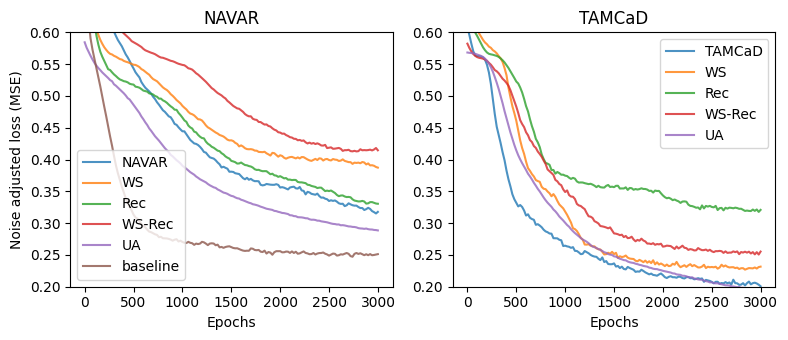

In [6]:
def plot_regression_noise_loss():

    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    
    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results.items()):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        axes[n_ax].plot(*result['test_metrics']['noise_adjusted_regression_loss'], label=model_name.replace(f'{tag}-', ''), alpha=0.8)
        axes[n_ax].set_title(tag)
        #axes[n_ax].set_xlim(100, 1000)
        axes[n_ax].set_ylim(0.2, 0.6)
        axes[n_ax].legend()
        if 'NAVAR' in model_name:
            axes[n_ax].set_ylabel('Noise adjusted loss (MSE)')
        axes[n_ax].set_xlabel('Epochs')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('noise_regression_losses.png', dpi=200)
    plt.show()
plot_regression_noise_loss()

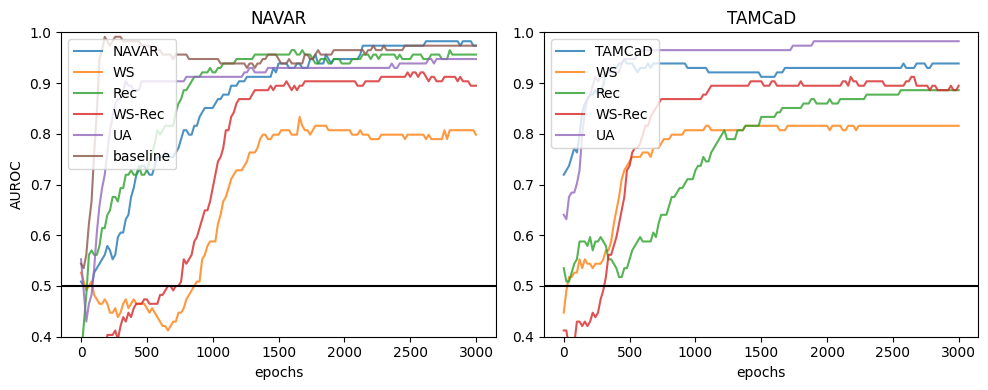

In [7]:
def plot_auroc():

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))


    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results.items()):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        axes[n_ax].plot(*result['test_metrics']['AUROC'], label=model_name.replace(f'{tag}-', '') , alpha=0.8)
        axes[n_ax].set_title(tag)
        #axes[n_ax].set_xlim(40, 1200)
        axes[n_ax].set_ylim(0.4, 1.0)
        axes[n_ax].set_xlabel('epochs')
        axes[n_ax].legend(loc='upper left')
    
    axes[0].axhline(y=0.5, color='black', linestyle='-')
    axes[1].axhline(y=0.5, color='black', linestyle='-')
    
    axes[0].set_ylabel('AUROC')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('plot_auroc.png', dpi=200)
    plt.show()
plot_auroc()